In [1]:
pip install pandas scikit-learn xgboost matplotlib joblib

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
    --------------------------------------- 1.0/56.8 MB 6.5 MB/s eta 0:00:09
    --------------------------------------- 1.3/56.8 MB 3.4 MB/s eta 0:00:17
   - -------------------------------------- 1.8/56.8 MB 2.9 MB/s eta 0:00:20
   -- ------------------------------------- 2.9/56.8 MB 3.5 MB/s eta 0:00:16
   -- ------------------------------------- 3.7/56.8 MB 3.5 MB/s eta 0:00:15
   --- ------------------------------------ 4.5/56.8 MB 3.6 MB/s eta 0:00:15
   --- ------------------------------------ 5.0/56.8 MB 3.4 MB/s eta 0:00:16
   ---- ----------------------------------- 6.0/56.8 MB 3.7 MB/s eta 0:00:14
   ---- ----------------------------------- 6.8/56.8 MB 3.7 MB/s eta 0:00:14
   ----- ---------------------------------- 7.6/56.8 MB 3.7 MB/s eta 0:00:14
   ----- ---------------------------------- 8.4/56.8 MB 3.7 MB/s eta 0:00:13
   ------ --------------------------------- 9.4/56.8 MB 3.7 MB/s eta 0:00:13
   ---

In [ ]:
import pandas as pd

# Load data (replace with your file paths if different)
train = pd.read_csv(r'C:\Users\pslas\Downloads\Train exp2.csv')
test = pd.read_csv(r'C:\Users\pslas\Downloads\Test exp2.csv')

# Preview
print(train.head())
print(test.head())
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


   id  gender   area qualification         income  marital_status  vintage  \
0   1    Male  Urban      Bachelor         5L-10L               1        5   
1   2    Male  Rural   High School         5L-10L               0        8   
2   3    Male  Urban      Bachelor         5L-10L               1        8   
3   4  Female  Rural   High School         5L-10L               0        7   
4   5    Male  Urban   High School  More than 10L               1        6   

   claim_amount num_policies policy type_of_policy    cltv  
0          5790  More than 1      A       Platinum   64308  
1          5080  More than 1      A       Platinum  515400  
2          2599  More than 1      A       Platinum   64212  
3             0  More than 1      A       Platinum   97920  
4          3508  More than 1      A           Gold   59736  
      id  gender   area qualification         income  marital_status  vintage  \
0  89393  Female  Rural   High School         5L-10L               0        6   
1  

In [3]:
# Info and stats
train.info()
train.describe()

# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())

# Unique values in categorical columns
print(train['gender'].unique())
print(train['area'].unique())
print(train['qualification'].unique())
print(train['income'].unique())
print(train['num_policies'].unique())
print(train['policy'].unique())
print(train['type_of_policy'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB
id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv 

In [6]:
#handling missing values 
train.fillna({'claim_amount': train['claim_amount'].median()}, inplace=True)
test.fillna({'claim_amount': test['claim_amount'].median()}, inplace=True)

In [7]:
#Feature Engineering 
# Ordinal mapping for income (low to high)
income_map = {'<=2L': 1, '2L-5L': 2, '5L-10L': 3, 'More than 10L': 4}
train['income_ordinal'] = train['income'].map(income_map)
test['income_ordinal'] = test['income'].map(income_map)

# Ordinal for type_of_policy (Silver < Gold < Platinum)
policy_type_map = {'Silver': 1, 'Gold': 2, 'Platinum': 3}
train['policy_type_ordinal'] = train['type_of_policy'].map(policy_type_map)
test['policy_type_ordinal'] = test['type_of_policy'].map(policy_type_map)

# Numeric for num_policies (frequency)
num_policies_map = {'1': 1, 'More than 1': 2}
train['num_policies_num'] = train['num_policies'].map(num_policies_map)
test['num_policies_num'] = test['num_policies'].map(num_policies_map)

# AOV (Average Order/Claim Value): claim_amount / frequency (avoid divide by 0)
train['aov'] = train['claim_amount'] / train['num_policies_num'].clip(lower=1)
test['aov'] = test['claim_amount'] / test['num_policies_num'].clip(lower=1)

# Recency: Lower vintage means more recent; use 1 / (vintage + 1) to normalize
train['recency'] = 1 / (train['vintage'] + 1)
test['recency'] = 1 / (test['vintage'] + 1)

##Frequency is already num_policies_num Drop original categorical if not needed (keep for now)

In [8]:
#prepare Features and Targets 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

features = ['gender', 'area', 'qualification', 'income_ordinal', 'marital_status', 'vintage', 
            'claim_amount', 'num_policies_num', 'policy', 'policy_type_ordinal', 'aov', 'recency']

X = train[features]
y = train['cltv']
X_test = test[features]

# Split train for validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Build Preprocessing pipeline
# Categorical to one-hot
categorical_features = ['gender', 'area', 'qualification', 'policy']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', [col for col in features if col not in categorical_features])
    ])

In [10]:
#train the model
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train
model.fit(X_train, y_train)

# Predict on validation
y_pred_val = model.predict(X_val)

# Validate
mae = mean_absolute_error(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 50136.81640625
RMSE: 82325.73274499293


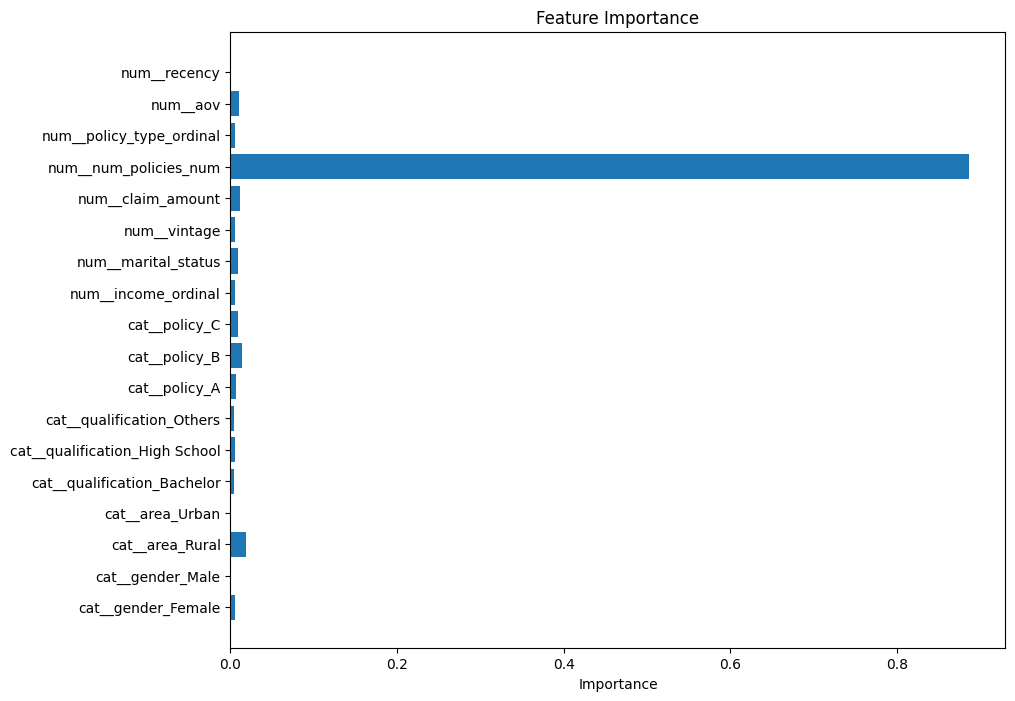

In [12]:
#Visualizations
import matplotlib.pyplot as plt

xgb_model = model.named_steps['regressor']
importance = xgb_model.feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(10, 8))
plt.barh(feature_names, importance)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

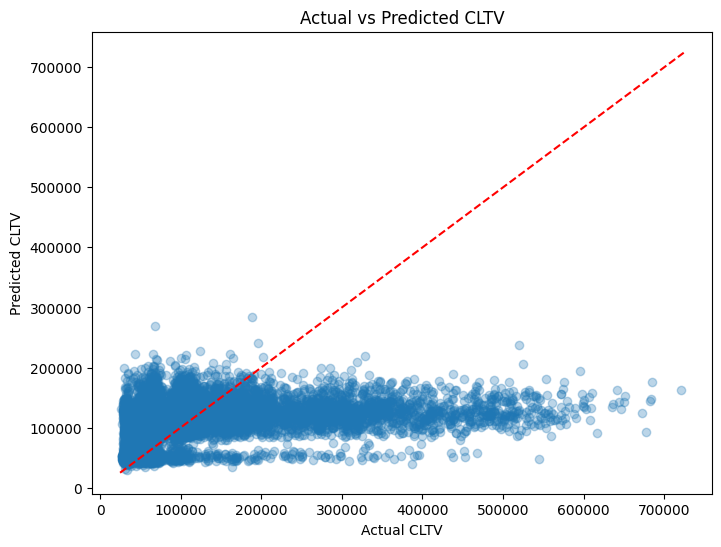

In [13]:
#actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_val, alpha=0.3)
plt.xlabel('Actual CLTV')
plt.ylabel('Predicted CLTV')
plt.title('Actual vs Predicted CLTV')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Perfect fit line
plt.show()

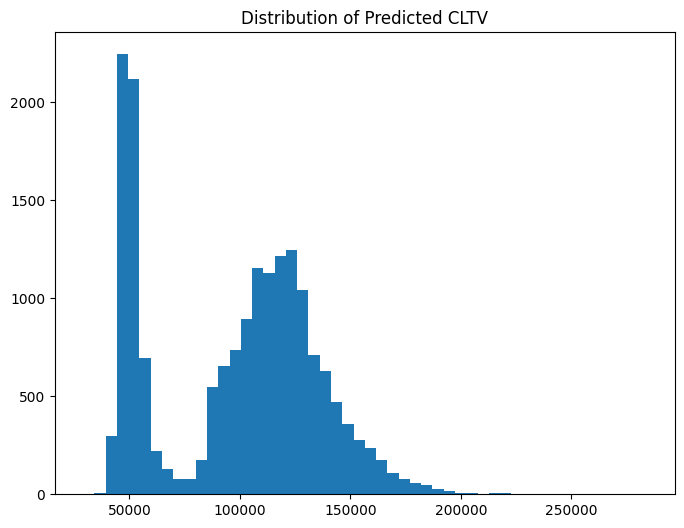

In [14]:
#Distribution of Predicted CLTV
plt.figure(figsize=(8, 6))
plt.hist(y_pred_val, bins=50)
plt.title('Distribution of Predicted CLTV')
plt.show()

In [15]:
#Predict on Test Set and Segment Customers
# Predict
test['predicted_cltv'] = model.predict(X_test)

# Segment (3 groups)
test['segment'] = pd.qcut(test['predicted_cltv'], q=3, labels=['Low', 'Medium', 'High'])

# Preview
print(test[['id', 'predicted_cltv', 'segment']].head())

      id  predicted_cltv segment
0  89393    87061.218750  Medium
1  89394   130499.773438    High
2  89395    91238.156250  Medium
3  89396    89077.796875  Medium
4  89397   104849.515625  Medium


In [16]:
import joblib
joblib.dump(model, 'cltv_model.pkl')

['cltv_model.pkl']